#### What is Financial returns ?

- When you pay to buy a stock for a company, its price changes overtime. That change — relative to what you paid — is called the return.
- Two common ways to calculate returns is 
    i) Simple arithematic returns (price diff/price) - easy to intepret but aren't additive over long periods of time
    ii) Logarithmic (Continuously Compounded) Return (log(price/yesterday's price)) - Easier for math and modeling, Often makes return distributions closer to normal. 
    > **Note** for smaller price changes both are going to be equal
- In practice, traders talk in simple returns (god hopes I can make atleast a 20% return one day!:P) while the Quant analysts / data scientists use log returns for modeling.

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
data = data[['Close']].dropna()
data.head()

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_62309/1339456897.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2020-01-02,72.538513
2020-01-03,71.833275
2020-01-06,72.405670
2020-01-07,72.065170
2020-01-08,73.224396


In [5]:
# Compute simple returns 
data['simple_returns'] = data['Close'].pct_change()

# Compute log returns 
data['log_returns'] = np.log(data['Close']/data['Close'].shift(1))

data = data.dropna()
data.head()

Price,Close,simple_returns,log_returns
Ticker,AAPL,,
Date,,,
2020-01-03,71.833275,-0.009722,-0.009770
2020-01-06,72.405670,0.007968,0.007937
2020-01-07,72.065170,-0.004703,-0.004714
2020-01-08,73.224396,0.016086,0.015958
2020-01-09,74.779770,0.021241,0.021019


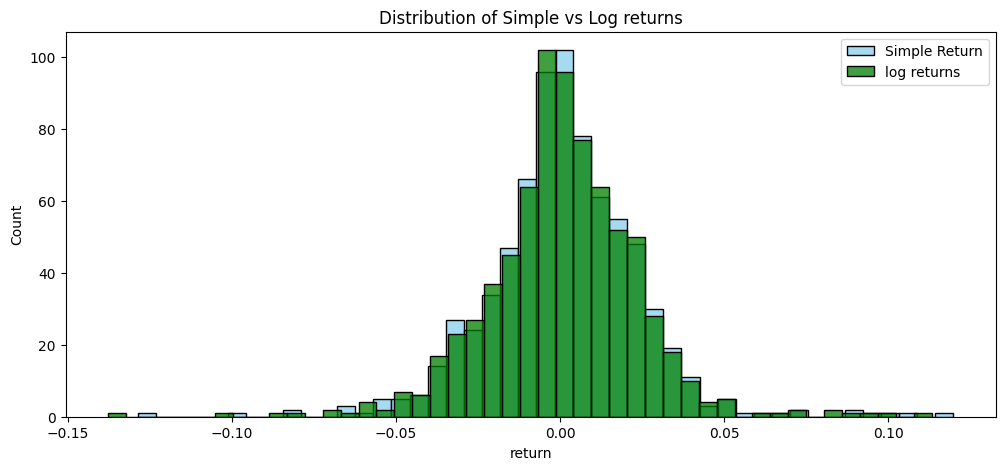

In [6]:
plt.figure(figsize=(12,5))
sns.histplot(data['simple_returns'], color='skyblue', label='Simple Return')
sns.histplot(data['log_returns'], color="green", label="log returns")
plt.legend()
plt.title("Distribution of Simple vs Log returns")
plt.xlabel("return")
plt.show()

In [9]:
data[["simple_returns", "log_returns"]].describe().T


,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
simple_returns,,755.0,0.001024,0.023266,-0.128647,-0.011103,0.000613,0.014153,0.119808
log_returns,,755.0,0.000753,0.023255,-0.137708,-0.011165,0.000612,0.014054,0.113157


#### Skewness:

- Measures asymmetry : positve skew (large right tail) means large positive returns and negative skew (long left tail) means more large losses

#### Kurtosis:

- High kurtosis (>3) = heavy tails (more extreme events than normal). Low kurtosis (<3) = light tails (less extreme events)

In [ ]:
print("Skewness:\n",data[["simple_returns", "log_returns"]].skew())
print("Kurtosis:\n",data[["simple_returns", "log_returns"]].kurtosis())

Skewness:
 Price           Ticker
simple_returns            0.095036
log_returns              -0.115789
dtype: float64
Kurtosis:
 Price           Ticker
simple_returns            4.040117
log_returns               4.134558
dtype: float64


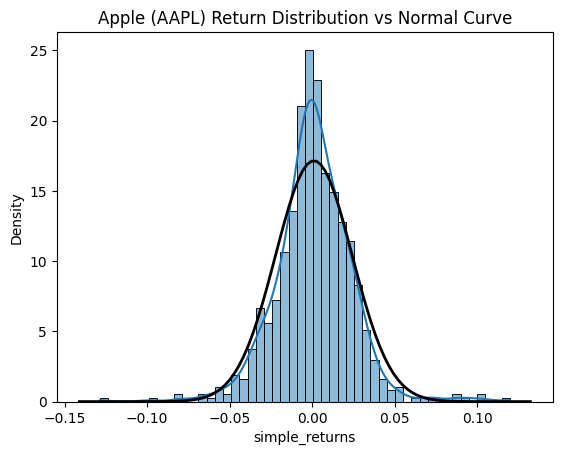

In [13]:
from scipy.stats import norm

mean = data['simple_returns'].mean()
variance = data['simple_returns'].var()
std_dev = data['simple_returns'].std()
sns.histplot(data['simple_returns'], bins=50, kde=True, stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Apple (AAPL) Return Distribution vs Normal Curve")
plt.show()

#### Normality Test (Jarque–Bera or Shapiro–Wilk)

##### Why we test for normality 

When we analyze the stocks returns, we often start with assumption that they are normally distributed (Ah! wht fun it would be if everything was just normal for once ps: not my life saying that lol:P) -i.e, returns are clustered around a mean with symmetric tails (bell curve)

However, in practice:
    - markets often have fat tails (cause you know it has has lots of up/downs like life!)
    - Distributions are skewed (losses are larger or more frequent than gains just like my muscle gains!)

So we conduct the normality test to verify whether this assumptuion holds because:
| Why it matters                | Example                                                                                                                              |
| ----------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| 📉 **Risk modeling**          | Models like Value-at-Risk (VaR) and Sharpe ratio assume normality. If returns aren’t normal, these can underestimate extreme losses. |
| 📈 **Statistical tests**      | Many hypothesis tests (like t-tests or regressions) assume normal residuals.                                                         |
| 💰 **Portfolio optimization** | Modern Portfolio Theory assumes returns are normally distributed to define “efficient frontiers.”                                    |
| 🧮 **Model choice**           | If non-normal, you might use *t-distributions*, *GARCH models*, or *Monte Carlo simulations* instead of simple Gaussian ones.        |

**In short — normality testing helps you decide whether you can safely use classic finance/stat models or need more robust ones.**

Statistical tests can confirm if returns deviate from normality:
p < 0.05 → reject normality → returns are not normally distributed
(which is usually true for financial data — fat tails & skewed)

We get stats and p from these tests : the statistic is a positive value that measures how much your data's skewness and kurtosis deviate from those of a normal distribution. The p-value is the probability of observing such a statistic if the returns were truly normal

## Jarque–Bera Test

Purpose: Tests whether sample skewness and kurtosis match a normal distribution.
It’s widely used in econometrics and finance because it directly checks the shape of the distribution.

Hypotheses:

    H₀: Data are normally distributed

    H₁: Data are not normally distributed

If p-value < 0.05, reject H₀ → not normal.

⚙️ Practical use:

Commonly run in econometrics reports, regression residuals, or model diagnostics.

Example: When validating ARIMA or GARCH models, analysts check if residuals are normal via JB test.

In [15]:
from scipy.stats import jarque_bera

stat, p = jarque_bera(data['simple_returns'])
print('Jarque-Bera Test: Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Jarque-Bera Test: Statistics=505.844, p=0.000
Sample does not look Gaussian (reject H0)


## Shapiro–Wilk Test

Purpose: Tests normality by comparing data order statistics to a theoretical normal distribution.
It’s more general and accurate for small to medium-sized samples (<5000).

Hypotheses:

H₀: Data come from a normal distribution

H₁: Data do not come from a normal distribution

How it works (conceptually):

- Sorts the data

- Compares how closely it fits the expected values if the data were normal

- Computes a statistic 𝑊: closer to 1 = more normal

⚙️ Practical use:

Used more in smaller samples (e.g., residuals of a regression)

For large datasets (like thousands of returns), it becomes too sensitive — almost always rejects normality.

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(data['simple_returns'])
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Shapiro-Wilk Test: Statistics=0.954, p=0.000
Sample does not look Gaussian (reject H0)
Jarque-Bera Test: Statistics=505.844, p=0.000
Sample does not look Gaussian (reject H0)


#### Which one should you use ?

| Test                                      | Best for                            | Based on              | Common in                                 |
| ----------------------------------------- | ----------------------------------- | --------------------- | ----------------------------------------- |
| **Jarque–Bera**                           | Large samples, finance/econometrics | Skewness + kurtosis   | Time series returns, residual diagnostics |
| **Shapiro–Wilk**                          | Small-medium samples                | Data quantile fitting | Experimental, regression residuals        |
| **Kolmogorov–Smirnov / Anderson–Darling** | Generic distribution testing        | CDF comparison        | Broader statistical use                   |


<span style="background-color: blue;">In financial time series (daily stock returns), Jarque–Bera is the standard.</span>

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_62309/479049895.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2022-01-01")['Close'].dropna()
[*********************100%***********************]  5 of 5 completed


Analyzing AAPL...
Analyzing MSFT...
Analyzing TSLA...
Analyzing GOOGL...
Analyzing AMZN...
:/search: Normlity Test Results
  Ticker  skewness  kurtosis    JB_Stat  JB_p  SW_Stat  SW_p
0   AAPL   -0.0105    5.2993   589.7391   0.0   0.9326   0.0
1   MSFT   -0.0746    9.5101  1899.7490   0.0   0.8920   0.0
2   TSLA    0.0889    3.4488   250.4353   0.0   0.9451   0.0
3  GOOGL   -0.1615    4.9685   520.6028   0.0   0.9279   0.0
4   AMZN    0.0921    2.1963   102.0121   0.0   0.9670   0.0


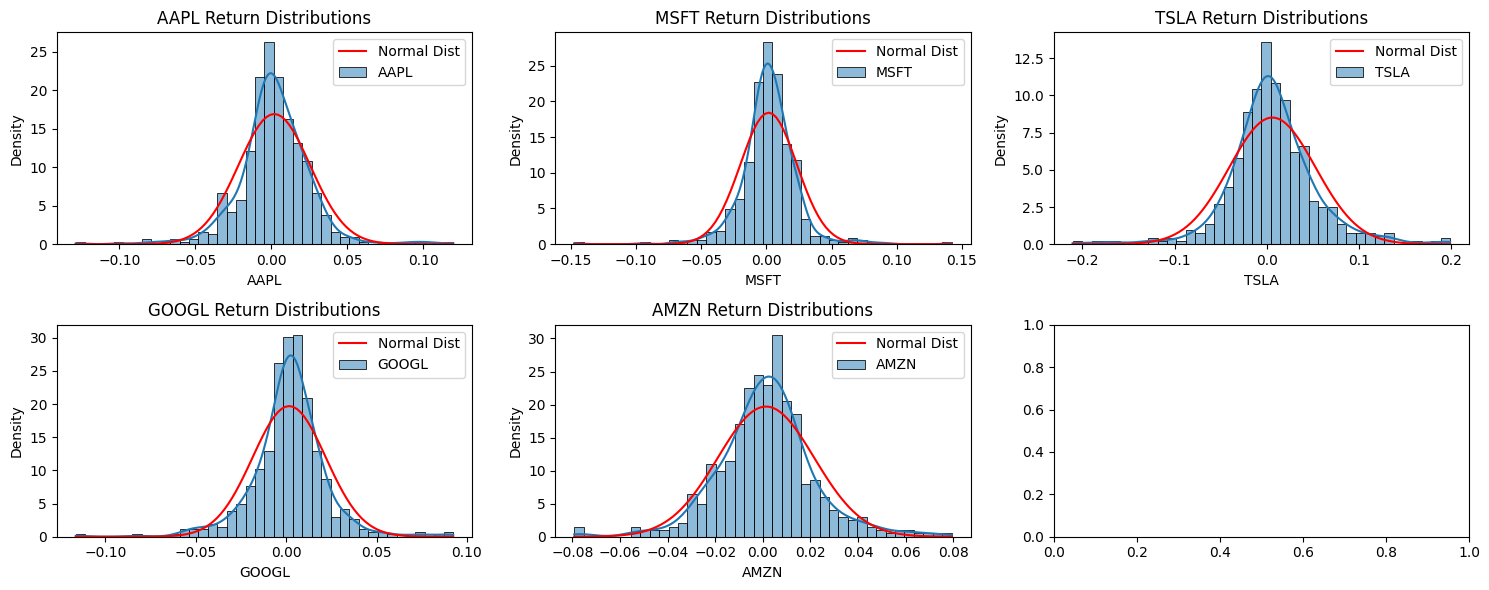

In [53]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera, shapiro, skew, kurtosis

tickers = ['AAPL', 'MSFT', "TSLA", "GOOGL", "AMZN"]

data = yf.download(tickers, start="2020-01-01", end="2022-01-01")['Close'].dropna()

returns = data.pct_change().dropna()

results = []

for ticker in tickers:
    print(f"Analyzing {ticker}...")

    series = returns[ticker].dropna()
    jb_stat, jb_p = jarque_bera(series)
    sw_stat, sw_p = shapiro(series.sample(500))

    results.append({
        'Ticker': ticker,
        'skewness': skew(series),
        'kurtosis': kurtosis(series, fisher=True),
        'JB_Stat': jb_stat,
        'JB_p': jb_p,
        'SW_Stat': sw_stat,
        'SW_p': sw_p
    })

results_df = pd.DataFrame(results)
print(":/search: Normlity Test Results")
print(results_df.round(4))

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for i, ticker in enumerate(tickers):
    if i<3:
        x = np.linspace(returns[ticker].min(), returns[ticker].max(), 100)
        sns.histplot(returns[ticker], bins=40, kde=True, stat='density', ax=axes[0][i], label=ticker)
        sns.lineplot(x=x, y=norm.pdf(x, returns[ticker].mean(), returns[ticker].std()), color='red', ax=axes[0][i], label='Normal Dist')
        axes[0][i].set_title(f"{ticker} Return Distributions")
    else:
        x = np.linspace(returns[ticker].min(), returns[ticker].max(), 100)
        sns.histplot(returns[ticker], bins=40, kde=True, stat='density', ax=axes[1][i-3], label=ticker)
        sns.lineplot(x=x, y=norm.pdf(x, returns[ticker].mean(), returns[ticker].std()), color='red', ax=axes[1][i-3], label='Normal Dist')
        axes[1][i-3].set_title(f"{ticker} Return Distributions")

    
plt.tight_layout()
plt.show()

Plotting AAPL...


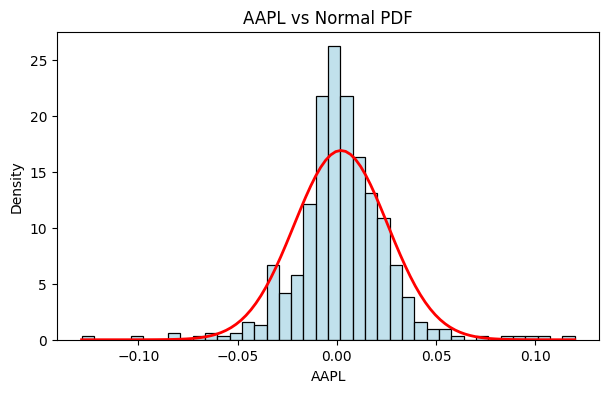

Plotting MSFT...


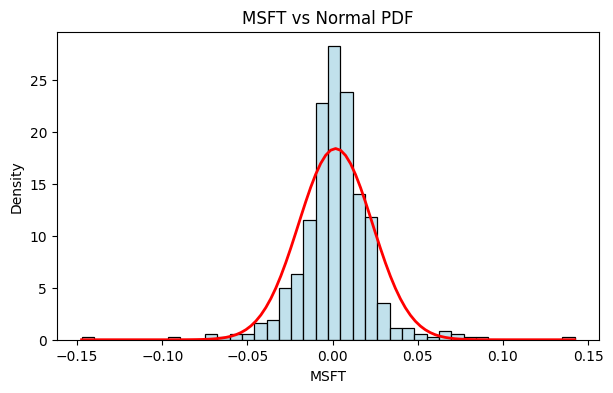

Plotting TSLA...


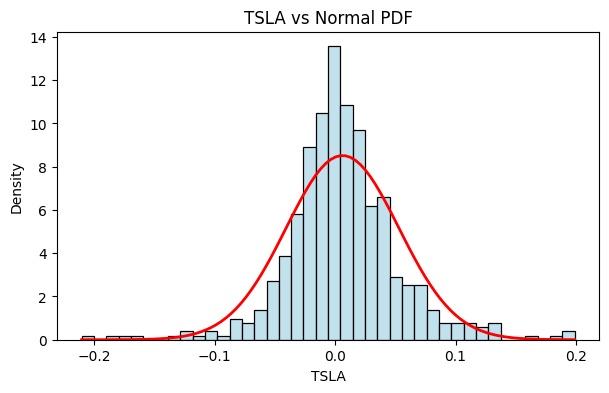

Plotting GOOGL...


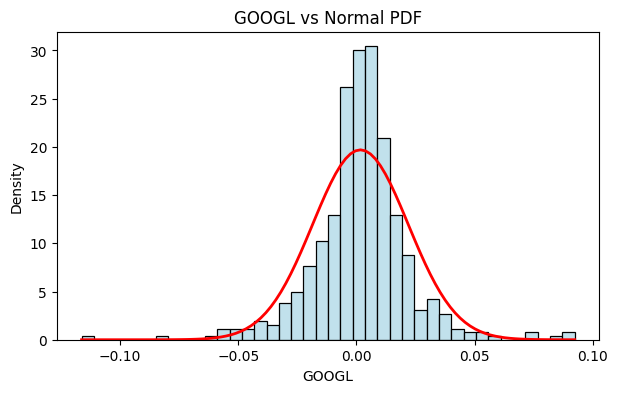

Plotting AMZN...


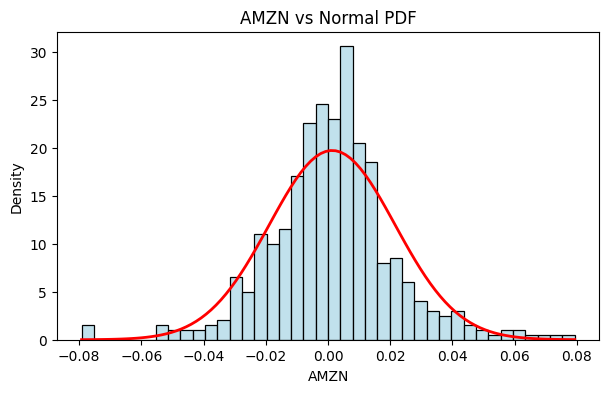

In [52]:
import numpy as np
from scipy.stats import norm

for ticker in tickers:
    print(f"Plotting {ticker}...")
    x = np.linspace(returns[ticker].min(), returns[ticker].max(), 100)
    plt.figure(figsize=(7,4))
    sns.histplot(returns[ticker], kde=False, stat='density', bins=40, color='lightblue')
    plt.plot(x, norm.pdf(x, returns[ticker].mean(), returns[ticker].std()), color='red', lw=2)
    plt.title(f"{ticker} vs Normal PDF")
    plt.show()


## What it means :

1. p-value = 0.0 -> both jarque and shapiro reject the null hypothesis of normality of stocks. This means none of the stocks return distribution is prefectly normal 

2. High Kurtosis(>3) -> "fat tails", markets experience more frequent large moves (crashes/spikes) than a normal distribution 

3. Skewness not equal to 0 -> returns arent symmetric.
    Negative skew (AAPL, GOOGL) = downside risk dominates
    Positive skew (TSLA, AMZN) = occasional big upswings

## Why it matters:

1. Risk Management:
Normal models (like Value-at-Risk assuming Gaussian tails) will underestimate real risk — they miss black-swan events.

2. Portfolio Optimization:
Mean-variance optimization assumes normality → may fail for assets like MSFT or TSLA that are highly kurtotic.

3. Model Choice:Instead of simple normal models, analysts use:

- t-distributions (fatter tails)

- GARCH-family models for volatility clustering

- nonparametric bootstrapping for robust risk estimation.

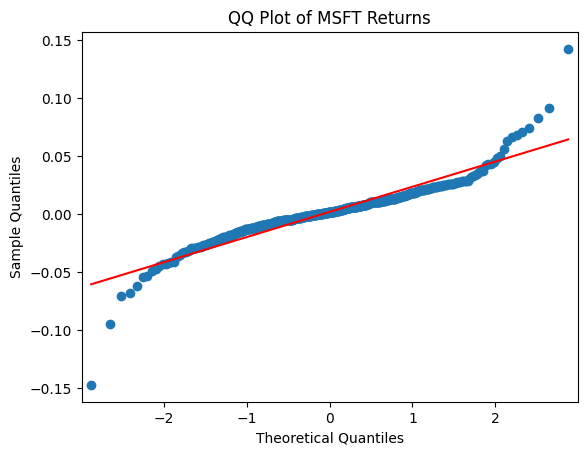

In [54]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

ticker = "MSFT"
sm.qqplot(returns[ticker], line='s')
plt.title(f"QQ Plot of {ticker} Returns")
plt.show()
